# Imports

In [2]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random
import math

# Right off of the bat, some assumptions I will be making:
- All trees & blazes are diffuse emitters (they evenly radiate their heat equally in all directions), except in wind conditions.

[1]: https://www.arborday.org/trees/treeguide/treedetail.cfm?itemID=879
[2]: https://www.srs.fs.usda.gov/pubs/misc/ag_654/volume_2/quercus/palustris.htm
[3]: https://assets.omega.com/pdf/tables_and_graphs/emissivity-table.pdf

# Pin Oak

## Some stuff about Pin Oak:
- A pin oak can grow anywhere from 60'-70'. ([1])
- Their final spread can be anywhere from 25'-40'. ([1])
- They burn easily due to a thin bark layer. ([2])
- The thermal emissivity of wood at low temperatures is anywhere from .8-.9. ([3])

## Tree height data:
- 60' -> 18.288m
- 70' -> 21.336m
- standard deviation for height: (21.336 - 18.288)/2 = 1.524m (Gaussian distribution)

## Tree spread data:
- 25' -> 7.62m
- 40' -> 12.192m
- standard deviation for spread: (12.192 - 7.62)/2 = 2.286m (Gaussian distribution)

# Set up constants

In [85]:
PIN_OAK_MIN_HT = 18.288 #m
PIN_OAK_HT_STD = 1.524 #m

PIN_OAK_MIN_SD = 7.62 #m
PIN_OAK_SD_STD = 2.286 #m

"""
                    +---------------------+
                    |     ____________    | -+
                    |    /            \   |  |
                    |   |             |   |  |
                    |    \  | || |  / /   |  |                Height:
                    |     \ |/ | / / |    |  |     +---------------------------+
                    |      \ \ || / /     |  +-----|min = 18.288m, std = 1.524m|
                    |       |      |      |  |     +---------------------------+
                    |       |      |      |  |
                    |       |      |      |  |
                    |       |      |      |  |
                    |       |      |      |  |
                    |______/________\_____| -+
                    +---------------------+
                         |            |
                         +-----+------+
                               |      Spread (of leaves):
                            +-------------------------+   
                            |min = 7.62m, std = 2.286m|
                            +-------------------------+
""";


WOOD_MIN_EMIS = .8
WOOD_MAX_EMIS = .9
WOOD_DIFF_EMIS = WOOD_MAX_EMIS - WOOD_MIN_EMIS

OAK_MIN_DENSITY = 600
OAK_MAX_DENSITY = 900
OAK_DIFF_DENSITY = OAK_MAX_DENSITY - OAK_MIN_DENSITY

#Stefan-Boltzmann constant
SBC = 5.67*(10**-8)

# FireBoard explanation:
## FireBoard contains a 2D matrix made up of "Cells" that represents a forest. These "Cells" represent a single tree in the forest (one Cell can only have one tree)
## Each Cell has data about the tree's height, its spread, and its temperature that are used in calculations during its execution of update().

[4]: https://www.britannica.com/science/wood-plant-tissue/Thermal-properties
# How does a fire work in a cell?
## Cell states:
- 0: No tree
- 1: Normal (default/inital state)
- 2: Heating up
- 3: Burning
- 4: Burnt out

## Setting a cell on fire:
### To set a given cell/tree on fire:
1. Set the given cell's state to 3
2. Set its temperature to 250°C
### Explanation:
#### 250°C is the temperature at which wood will combust with a spark. ([4])
#### Wood will auto-ignite at around 500°C (no spark required to become engulfed in flames) ([4])

In [175]:
class FireBoard:

    #Create FireBoard
    def __init__(self, board=None, nrows=None, ncols=None, tree_chance=.65, wdir=0, wspd=0, constant_wind=True):
        self.rows = 20
        self.cols = 20
        
        self.wind_matrix = np.array([
            [0]*5,
            [0, 1, 1, 1, 0],
            [0, 1, 2, 1, 0],
            [0, 1, 1, 1, 0],
            [0]*5
        ])

        if board is not None:
            self.board = board
            self.rows = len(board)
            self.cols = len(board[0])
        else:
            if (nrows is not None) and (nrows >= 3):
                self.rows = nrows
            if (ncols is not None) and (ncols >= 3):
                self.cols = ncols

            self.board = np.array(
                [[self.random_cell(i, j, chance=tree_chance)
                  for j in range(self.cols)]
                 for i in range(self.rows)],
                dtype="object"
            )

    class Cell:
        #Create cell
        def __init__(self, x, y, height=None, spread=None, temp=None):
            self.state = 1
            
            self.tree_burning = 0.0
            self.emissivity = WOOD_DIFF_EMIS*random.random()+WOOD_MIN_EMIS
            
            self.moore_neighbors = [
                (-1, -1), #Top left
                (-1, 0),  #Top center
                (-1, 1),  #Top right
                (0, -1),  #Mid left
                (0, 1),   #Mid right
                (1, -1),  #Bot left
                (1, 0),   #Bot center
                (1, 1)    #Bot right
            ]
            
            #Cell's position
            self.x = x
            self.y = y

            #If no height has been provided, give our own random height based off of
            #pin oak statistical data
            if height is None:
                self.height = PIN_OAK_HT_STD*random.random()+PIN_OAK_MIN_HT
                if temp is None:
                    self.temp = 1*random.random()+24.5
                else:
                    self.temp = temp
            else:
                self.height = height
                self.temp = 25;

                if height == 0:
                    self.state = 0

            #Set up the tree's "spread"
            #No height = no tree = no spread
            if height == 0:
                self.spread = 0
                self.trunk = 0
            else:
                self.trunk = 1 #m
                #Generate random tree spread from pin oak statistics
                if spread is None:
                    self.spread = PIN_OAK_SD_STD*random.random()+PIN_OAK_MIN_SD
                else:
                    self.spread = spread

            #Radius of tree, distance of bark from center for any angle
            self.radius = self.trunk / 2
            self.density = OAK_DIFF_DENSITY*random.random()+OAK_MIN_DENSITY

            self.mass = math.pi*pow(self.radius, 2)*self.height*self.density
            
            self.bark_area = 2*math.pi*self.radius*self.height

        #Define what a Cell does in state 1: See if it has any risk of burning
        def state1(self, board):
            
            #Find the highest state of all neighbours in the Moore neighborhood
            max_state = self.state

            #For all Moore neighbors
            for index in self.moore_neighbors:
                #Check if the Moore neighbor is beyond the bounds of the board
                past_vert_wall = self.x+index[0] < 0 or self.x+index[0] > (len(board)-1)
                past_horz_wall = self.y+index[1] < 0 or self.y+index[1] > (len(board[0])-1)
                past_wall = past_vert_wall or past_horz_wall

                if not past_wall and max_state < board[self.x+index[0]][self.y+index[1]].state:
                    max_state = board[self.x+index[0]][self.y+index[1]].state

            #Check the highest state in the Moore neighborhood and set current cell's value accordingly
            if (max_state >= 3) and (self.state <= 2):
                self.state = 2

        #Defines how the temperatures between two Cells will interact when in state 2 (heating up)
        def state2(self, board):
            temp_sum = 0
            actual_moore_neighbors = 0
            #For all Moore neighbors
            for index in self.moore_neighbors:
                #Check if the Moore neighbor is beyond the bounds of the board
                past_vert_wall = self.x+index[0] < 0 or self.x+index[0] > (len(board)-1)
                past_horz_wall = self.y+index[1] < 0 or self.y+index[1] > (len(board[0])-1)
                past_wall = past_vert_wall or past_horz_wall
                
                if not past_wall and board[self.x+index[0]][self.y+index[1]].height > 0:
                    temp_sum += board[self.x+index[0]][self.y+index[1]].temp
                    actual_moore_neighbors += 1
            self.temp = temp_sum / actual_moore_neighbors
            
            if self.temp >= 250:
                self.state = 3

        def burn(self):
            if self.tree_burning == 1.0:
                self.state = 4
            else:
                self.tree_burning += .05
                if self.tree_burning > 1.0:
                    self.tree_burning = 1.0

                if self.temp < 1000:
                    self.temp += 100 * self.tree_burning
                    #Highest temperature for a wood fire is around 1000°C
                    if self.temp > 1000:
                        self.temp = 1000

        def state4(self, board):
            temp_sum = self.temp
            actual_moore_neighbors = 0
            #For all Moore neighbors
            for index in self.moore_neighbors:
                #Check if the Moore neighbor is beyond the bounds of the board
                past_vert_wall = self.x+index[0] < 0 or self.x+index[0] > (len(board)-1)
                past_horz_wall = self.y+index[1] < 0 or self.y+index[1] > (len(board[0])-1)
                past_wall = past_vert_wall or past_horz_wall
                
                if not past_wall:
                    temp_sum += board[self.x+index[0]][self.y+index[1]].temp
                    actual_moore_neighbors += 1
            self.temp = temp_sum / actual_moore_neighbors


        def update(self, board):
            if self.height == 0:   #No tree = no change
                return 0

            if self.state == 1:    #Normal state of tree
                self.state1(board)

            elif self.state == 2:  #At risk of burning/Heating up
                self.state2(board)

            elif self.state == 3:  #Burning
                self.burn()

            elif self.state == 4:  #Burnt out
                self.state4(board)

            return self.state


    #Create and return a random cell with given criteria
    def random_cell(self, x, y, ht=None, chance=.65):
        if random.random() >= 1-chance:
            return self.Cell(x, y, height=ht)
        else:
            return self.Cell(x, y, height=0)

    def update(self):
        for index, cell in np.ndenumerate(fb.board):
            cell.update(self.board)

    def imshow_state(self):
        fig, ax = plt.subplots()
        im = ax.imshow([[self.board[i][j].state for j in range(self.cols)] for i in range(self.rows)], cmap="Paired_r")
        ax.set_title("Cell States")
        ax.set_axis_off()
        fig.colorbar(im, ax=ax)
        return fig, ax

    def imshow_height(self):
        fig, ax = plt.subplots()
        im = ax.imshow([[self.board[i][j].height for j in range(self.cols)] for i in range(self.rows)], cmap="copper")
        ax.set_title("Cell Heights")
        ax.set_axis_off()
        fig.colorbar(im, ax=ax)
        return fig, ax

    def imshow_temp(self):
        fig, ax = plt.subplots()
        im = ax.imshow([[self.board[i][j].temp for j in range(self.cols)] for i in range(self.rows)], cmap="jet")
        ax.set_title("Cell Temperatures")
        ax.set_axis_off()
        fig.colorbar(im, ax=ax)
        return fig, ax

    def imshow_spread(self):
        fig, ax = plt.subplots()
        im = ax.imshow([[self.board[i][j].spread for j in range(self.cols)] for i in range(self.rows)], cmap="copper")
        ax.set_title("Cell Spreads")
        ax.set_axis_off()
        fig.colorbar(im, ax=ax)
        return fig, ax

### How to calculate emitted heat
#### E = emissivity * (View factor, F_ij) * (Area of emission) * (Stefan-Boltzmann constant) * (temperature^4)
#### Stefan-Botlzmann constant: 5.67*10^-8 W/(m^2 * K^4)

### How to calculate heat absorbed
#### E = absorption * (incident heat)

### View factor
#### F_{ij} = ((cos(\theta_i) * cos(theta_j))/(pi*s^2))*A_j
#### => F_{ij} = 1/(pi*s^2) A_j

In [167]:
ci = FireBoard.Cell(0, 0)
cj = FireBoard.Cell(0, 1)

ci.temp = 250

print(f"ci.temp: {ci.temp}")
print(f"cj.temp: {cj.temp}")
print(f"cj.radius: {cj.radius}")
print(f"cj.height: {cj.height}")
print(f"cj volume: {math.pi*pow(cj.radius, 2)*cj.height}")
print(f"cj.density: {cj.density}")
print(f"cj.mass: {cj.mass}")
          #ci
s = 16 - ((ci.trunk + ci.spread*.3) + (cj.trunk + cj.spread*.3))

f_ij = 1/(math.pi*(s**2)) * cj.bark_area/2 #m^-1
print("F_ij:", f_ij)
q_tr = ci.emissivity * f_ij * ci.bark_area/2 * SBC * ci.temp**4
q_tr *= 2
print("Heat transferred:", q_tr, "J")

#specific heat capacity of wood 1.7
cj_new_temp = ((q_tr) / (cj.mass * 1.7)) + cj.temp
print("New temperature:", cj_new_temp)
print("Temp difference:", cj_new_temp - cj.temp)

ci.temp: 250
cj.temp: 25.1101554963847
cj.radius: 0.5
cj.height: 19.376749285971073
cj volume: 15.218463301814499
cj.density: 683.7556698074219
cj.mass: 10405.710568371842
F_ij: 0.12094652573494467
Heat transferred: 1332.4667700458765 J
New temperature: 25.1854799038079
Temp difference: 0.07532440742319935


## Choose random starting Cell for fire

36 65


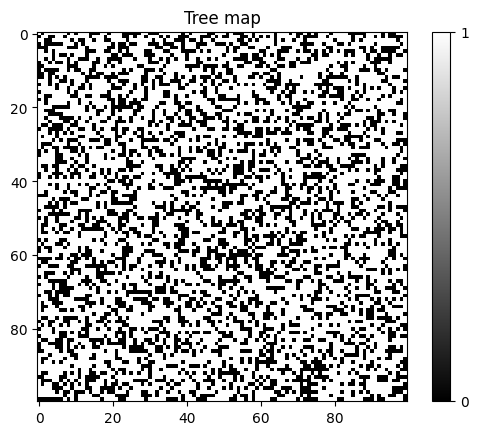

0/1000
0/1000
1/1000
2/1000
3/1000
4/1000
5/1000
6/1000
7/1000
8/1000
9/1000
10/1000
11/1000
12/1000
13/1000
14/1000
15/1000
16/1000
17/1000
18/1000
19/1000
20/1000
21/1000
22/1000
23/1000
24/1000
25/1000
26/1000
27/1000
28/1000
29/1000
30/1000
31/1000
32/1000
33/1000
34/1000
35/1000
36/1000
37/1000
38/1000
39/1000
40/1000
41/1000
42/1000
43/1000
44/1000
45/1000
46/1000
47/1000
48/1000
49/1000
50/1000
51/1000
52/1000
53/1000
54/1000
55/1000
56/1000
57/1000
58/1000
59/1000
60/1000
61/1000
62/1000
63/1000
64/1000
65/1000
66/1000
67/1000
68/1000
69/1000
70/1000
71/1000
72/1000
73/1000
74/1000
75/1000
76/1000
77/1000
78/1000
79/1000
80/1000
81/1000
82/1000
83/1000
84/1000
85/1000
86/1000
87/1000
88/1000
89/1000
90/1000
91/1000
92/1000
93/1000
94/1000
95/1000
96/1000
97/1000
98/1000
99/1000
100/1000
101/1000
102/1000
103/1000
104/1000
105/1000
106/1000
107/1000
108/1000
109/1000
110/1000
111/1000
112/1000
113/1000
114/1000
115/1000
116/1000
117/1000
118/1000
119/1000
120/1000
121/1000
122/1

923/1000
924/1000
925/1000
926/1000
927/1000
928/1000
929/1000
930/1000
931/1000
932/1000
933/1000
934/1000
935/1000
936/1000
937/1000
938/1000
939/1000
940/1000
941/1000
942/1000
943/1000
944/1000
945/1000
946/1000
947/1000
948/1000
949/1000
950/1000
951/1000
952/1000
953/1000
954/1000
955/1000
956/1000
957/1000
958/1000
959/1000
960/1000
961/1000
962/1000
963/1000
964/1000
965/1000
966/1000
967/1000
968/1000
969/1000
970/1000
971/1000
972/1000
973/1000
974/1000
975/1000
976/1000
977/1000
978/1000
979/1000
980/1000
981/1000
982/1000
983/1000
984/1000
985/1000
986/1000
987/1000
988/1000
989/1000
990/1000
991/1000
992/1000
993/1000
994/1000
995/1000
996/1000
997/1000
998/1000
999/1000
Done.
CPU times: total: 1min 50s
Wall time: 2min 30s
0/1000


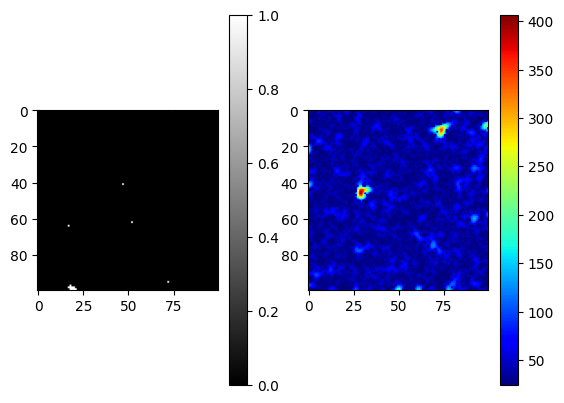

In [187]:
%%time
fb = FireBoard(nrows=100, ncols=100)

rx, ry = int(random.random()*fb.rows), int(random.random()*fb.cols)

while True:
    if fb.board[rx][ry].state == 0:
        rx, ry = int(random.random()*fb.rows), int(random.random()*fb.cols)
    else:
        break
print(rx, ry)

fb.board[rx][ry].state = 3
fb.board[rx][ry].temp = 250
fb.board[rx][ry].tree_burning = .01

plt.imshow([[fb.board[i][j].height > 0 for j in range(fb.cols)] for i in range(fb.rows)], cmap="gray")
plt.title("Tree map")
plt.colorbar(ticks=[0, 1])
plt.show()

def is_tree(state):
    return (state < 4) and (state > 0)

fig, (ax0, ax1) = plt.subplots(1, 2)
im_tree = ax0.imshow([[is_tree(fb.board[i][j].state) for j in range(fb.cols)] for i in range(fb.rows)], cmap="gray")
fig.colorbar(im_tree, ax=ax0)
im_temp = ax1.imshow([[fb.board[i][j].temp for j in range(fb.cols)] for i in range(fb.rows)], cmap="jet")
fig.colorbar(im_temp, ax=ax1)

def animate(frame):
    fb.update()
    im_tree.set_data([[is_tree(fb.board[i][j].state) for j in range(fb.cols)] for i in range(fb.rows)])
    im_tree.autoscale()
    im_temp.set_data([[fb.board[i][j].temp for j in range(fb.cols)] for i in range(fb.rows)])
    im_temp.autoscale()
    print(f"{frame}/1000")
    return [im]

anim = FuncAnimation(fig, animate, frames=1000, interval=500)
anim.save("burn.mp4")
print("Done.")

# Create burning animation

In [6]:
%matplotlib notebook

tree_chance = .6

cells = [[cell(height=None) if random.random() >= (1-tree_chance) else cell(height=0) for j in range(20)] for i in range(20)]

plt.close()
fig, ax = plt.subplots()

def get_heights(data):
    rows = len(data)
    cols = len(data[0])
    return [[data[i][j].height for j in range(cols)] for i in range(rows)]

row = math.floor(random.random()*20)
col = math.floor(random.random()*20)

cells[row][col].height = 25

im = ax.imshow(get_heights(cells), cmap='viridis')
ax.set_xticks([])
ax.set_yticks([])

def animate(frame_num):
    cells[row][col].burn()
    im.set_data(get_heights(cells))
    im.autoscale()
    return [im]

anim = FuncAnimation(fig, animate, frames=10, interval=1000)
anim.save("tree.mp4")
plt.show()
print("Done.")

# References/Works Cited
- [1]: https://www.srs.fs.usda.gov/pubs/misc/ag_654/volume_2/quercus/palustris.htm
[1]